In [23]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from joblib import dump, load

from pyod.models.abod import ABOD
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.utils.utility import precision_n_scores, standardizer
from sklearn.metrics import auc, f1_score, roc_auc_score, roc_curve

from autocustom import AutoEncoderCustom

from datautil import *

In [26]:
def get_dataset(dataset_name: str):
    if dataset_name == 'mnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    elif dataset_name == 'fashion_mnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    elif dataset_name == 'cifar10':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    elif dataset_name == 'kminst':
        x_train = np.load('./kmnist/kmnist-train-imgs.npz')['arr_0']
        x_test = np.load('./kmnist/kmnist-test-imgs.npz')['arr_0']
        y_train = np.load('./kmnist/kmnist-train-labels.npz')['arr_0']
        y_test = np.load('./kmnist/kmnist-test-labels.npz')['arr_0']
    else:
        raise('Error')

    return x_train, y_train, x_test, y_test

In [48]:
# config
dataset_name = "mnist"
dataset_name = "fashion_mnist"
#dataset_name = "kminst"
outlier_fraction = 0.1


x_train, y_train, x_test, y_test = get_dataset(dataset_name)

n_features = np.prod(x_train.shape[1:])
x_train = x_train.reshape(x_train.shape[0], n_features) / 255.0
x_test = x_test.reshape(x_test.shape[0], n_features) / 255.0

num_classes = np.unique(y_train).size
num_nodes_per_class = 9  # p parameter, set (to num_class - 1) * d

print(x_train.shape)
print(x_test.shape)


(60000, 784)
(10000, 784)


In [49]:
# dict of dataset, key is client name 
datasets = partition2(x_train,y_train, num_nodes_per_class, outlier_fraction)


request, remaining 66 25


In [66]:
# verify
datasets.keys()
datasets['0_4']['y_class'].value_counts()
datasets['0_2']['y_out'].value_counts()

dict_keys(['0_0', '0_1', '0_2', '0_3', '0_4', '0_5', '0_6', '0_7', '0_8', '1_0', '1_1', '1_2', '1_3', '1_4', '1_5', '1_6', '1_7', '1_8', '2_0', '2_1', '2_2', '2_3', '2_4', '2_5', '2_6', '2_7', '2_8', '3_0', '3_1', '3_2', '3_3', '3_4', '3_5', '3_6', '3_7', '3_8', '4_0', '4_1', '4_2', '4_3', '4_4', '4_5', '4_6', '4_7', '4_8', '5_0', '5_1', '5_2', '5_3', '5_4', '5_5', '5_6', '5_7', '5_8', '6_0', '6_1', '6_2', '6_3', '6_4', '6_5', '6_6', '6_7', '6_8', '7_0', '7_1', '7_2', '7_3', '7_4', '7_5', '7_6', '7_7', '7_8', '8_0', '8_1', '8_2', '8_3', '8_4', '8_5', '8_6', '8_7', '8_8', '9_0', '9_1', '9_2', '9_3', '9_4', '9_5', '9_6', '9_7', '9_8'])

0    593
2     11
6      9
5      9
4      8
3      8
8      7
7      5
1      5
9      4
Name: y_class, dtype: int64

TypeError: value_counts() got an unexpected keyword argument 'density'

In [51]:
# convert to object Dev
devs = []
for name, data, in datasets.items():
    #print(name,dataset_name)
    x = data.iloc[:,:n_features]
    y_class = data['y_class']
    devs = devs + [Dev(name, dataset_name, x, y_class)]



In [52]:
#mod = OCSVM(contamination=outlier_fraction)
#mod = AutoEncoder(contamination=outliers_fraction, hidden_neurons = [64, 32, 64], dropout_rate=0.1, verbose=0, preprocessing=False)
#mod = IForest(contamination=outlier_fraction)

for dev in devs:
    dev.model_fit(
        #OCSVM(contamination=outlier_fraction,cache_size=1000),
        #AutoEncoder(contamination=outlier_fraction, hidden_neurons = [16, 8, 16], dropout_rate=0.1, verbose=0, preprocessing=False),
        AutoEncoderCustom(contamination=outlier_fraction, hidden_neurons = [16, 8, 16], dropout_rate=0.1, verbose=0, preprocessing=False),
        num_nodes_per_class=num_nodes_per_class
        )

Reading model ./data_step1_models/9/mnist/AutoEncoderCustom/0_0.joblib
Reading model ./data_step1_models/9/mnist/AutoEncoderCustom/0_1.joblib
Reading model ./data_step1_models/9/mnist/AutoEncoderCustom/0_2.joblib
Reading model ./data_step1_models/9/mnist/AutoEncoderCustom/0_3.joblib
Reading model ./data_step1_models/9/mnist/AutoEncoderCustom/0_4.joblib
Reading model ./data_step1_models/9/mnist/AutoEncoderCustom/0_5.joblib
Reading model ./data_step1_models/9/mnist/AutoEncoderCustom/0_6.joblib
Reading model ./data_step1_models/9/mnist/AutoEncoderCustom/0_7.joblib
Reading model ./data_step1_models/9/mnist/AutoEncoderCustom/0_8.joblib
Reading model ./data_step1_models/9/mnist/AutoEncoderCustom/1_0.joblib
Reading model ./data_step1_models/9/mnist/AutoEncoderCustom/1_1.joblib
Reading model ./data_step1_models/9/mnist/AutoEncoderCustom/1_2.joblib
Reading model ./data_step1_models/9/mnist/AutoEncoderCustom/1_3.joblib
Reading model ./data_step1_models/9/mnist/AutoEncoderCustom/1_4.joblib
Readin

In [53]:
for i in reversed(devs): 
    i.set_other_models(devs)
#for i in devs:
    #i.write_other_models(devs)

9_8 full pred 90 received
9_7 full pred 90 received
9_6 full pred 90 received
9_5 full pred 90 received
9_4 full pred 90 received
9_3 full pred 90 received
9_2 full pred 90 received
9_1 full pred 90 received
9_0 full pred 90 received
8_8 full pred 90 received
8_7 full pred 90 received
8_6 full pred 90 received
8_5 full pred 90 received
8_4 full pred 90 received
8_3 full pred 90 received
8_2 full pred 90 received
8_1 full pred 90 received
8_0 full pred 90 received
7_8 full pred 90 received
7_7 full pred 90 received
7_6 full pred 90 received
7_5 full pred 90 received
7_4 full pred 90 received
7_3 full pred 90 received
7_2 full pred 90 received
7_1 full pred 90 received
7_0 full pred 90 received
6_8 full pred 90 received
6_7 full pred 90 received
6_6 full pred 90 received
6_5 full pred 90 received
6_4 full pred 90 received
6_3 full pred 90 received
6_2 full pred 90 received
6_1 full pred 90 received
6_0 full pred 90 received
5_8 full pred 90 received
5_7 full pred 90 received
5_6 full pre

In [54]:
tot = {}
for dev in devs:
    tot[dev] = dev.get_senders_perc_normal()
dm = pd.DataFrame.from_dict(tot)
#dm.style.background_gradient(cmap='Blues', axis=None)

In [55]:
#idd=2
#devs[idd]
for m in devs:
    m
    devs_federated = m.get_devs_federated(0.06)
    print(*devs_federated, sep=', ')

0_0

0_0, 0_1, 0_2, 0_3, 0_4, 0_5, 0_6, 0_8


0_1

0_0, 0_1, 0_3, 0_4, 0_5, 0_6, 0_8


0_2

0_0, 0_2, 0_3, 0_4, 0_5, 0_6, 0_7, 0_8


0_3

0_0, 0_1, 0_2, 0_3, 0_4, 0_5, 0_6, 0_8, 4_0


0_4

0_0, 0_1, 0_2, 0_3, 0_4, 0_5, 0_6, 0_8


0_5

0_0, 0_1, 0_2, 0_3, 0_4, 0_5, 0_6, 0_8


0_6

0_0, 0_1, 0_2, 0_3, 0_4, 0_5, 0_6, 0_8


0_7

0_2, 0_7, 2_1, 2_2


0_8

0_0, 0_1, 0_2, 0_3, 0_4, 0_5, 0_6, 0_8


1_0

1_0, 1_1, 1_2, 1_3, 1_4, 1_5, 1_6, 1_7, 1_8


1_1

1_0, 1_1, 1_2, 1_3, 1_4, 1_5, 1_6, 1_7, 1_8


1_2

1_0, 1_1, 1_2, 1_3, 1_4, 1_5, 1_6, 1_7, 1_8


1_3

1_0, 1_1, 1_2, 1_3, 1_4, 1_5, 1_6, 1_7, 1_8


1_4

1_0, 1_1, 1_2, 1_3, 1_4, 1_5, 1_6, 1_7, 1_8


1_5

1_0, 1_1, 1_2, 1_3, 1_4, 1_5, 1_6, 1_7, 1_8


1_6

1_0, 1_1, 1_2, 1_3, 1_4, 1_5, 1_6, 1_7, 1_8


1_7

1_0, 1_1, 1_2, 1_3, 1_4, 1_5, 1_6, 1_7, 1_8


1_8

1_0, 1_1, 1_2, 1_3, 1_4, 1_5, 1_6, 1_7, 1_8


2_0

2_0, 2_1, 2_2, 2_3, 2_4, 2_5, 2_6, 2_8


2_1

0_7, 2_0, 2_1, 2_2, 2_3, 2_4, 2_5, 2_6, 2_7, 2_8


2_2

0_7, 2_0, 2_1, 2_2, 2_3, 2_4, 2_5, 2_6, 3_7


2_3

2_0, 2_1, 2_2, 2_3, 2_5, 2_6


2_4

2_0, 2_1, 2_2, 2_4, 2_5, 2_7, 2_8


2_5

2_0, 2_1, 2_2, 2_3, 2_4, 2_5, 2_6, 2_8


2_6

2_0, 2_1, 2_2, 2_3, 2_5, 2_6, 2_8, 3_7


2_7

2_1, 2_4, 2_7, 2_8, 6_0


2_8

2_0, 2_1, 2_4, 2_5, 2_6, 2_7, 2_8, 6_0


3_0

3_0, 3_1, 3_2, 3_3, 3_4, 3_5, 3_6, 3_8


3_1

3_0, 3_1, 3_3, 3_4, 3_6, 3_8


3_2

3_0, 3_2, 3_3, 3_4, 3_5, 3_7, 3_8


3_3

3_0, 3_1, 3_2, 3_3, 3_4, 3_5, 3_6, 3_7, 3_8, 5_2, 5_6


3_4

3_0, 3_1, 3_2, 3_3, 3_4, 3_6, 3_8, 5_1


3_5

3_0, 3_2, 3_3, 3_5, 3_7, 3_8, 5_5, 5_6


3_6

3_0, 3_1, 3_3, 3_4, 3_6, 3_8


3_7

2_2, 2_6, 3_2, 3_3, 3_5, 3_7, 3_8, 5_0


3_8

3_0, 3_1, 3_2, 3_3, 3_4, 3_5, 3_6, 3_7, 3_8, 5_6


4_0

0_3, 4_0, 4_1, 4_2, 4_3, 4_4, 4_5, 4_6, 4_8


4_1

4_0, 4_1, 4_6


4_2

4_0, 4_2, 4_3, 4_4, 4_5, 4_6, 4_7, 4_8


4_3

4_0, 4_2, 4_3, 4_4, 4_5, 4_6, 4_8


4_4

4_0, 4_2, 4_3, 4_4, 4_5, 4_7, 4_8


4_5

4_0, 4_2, 4_3, 4_4, 4_5, 4_6, 4_8


4_6

4_0, 4_1, 4_2, 4_3, 4_5, 4_6, 4_8


4_7

4_2, 4_4, 4_7


4_8

4_0, 4_2, 4_3, 4_4, 4_5, 4_6, 4_8


5_0

3_7, 5_0, 5_2, 5_3, 5_4, 5_5, 5_6, 5_7, 5_8


5_1

3_4, 5_1, 5_6


5_2

3_3, 5_0, 5_2, 5_3, 5_5, 5_6, 5_8


5_3

5_0, 5_2, 5_3, 5_4, 5_5, 5_6, 5_8


5_4

5_0, 5_3, 5_4, 5_7, 5_8


5_5

3_5, 5_0, 5_2, 5_3, 5_5, 5_6, 5_8


5_6

3_3, 3_5, 3_8, 5_0, 5_1, 5_2, 5_3, 5_5, 5_6, 5_8


5_7

5_0, 5_4, 5_7


5_8

5_0, 5_2, 5_3, 5_4, 5_5, 5_6, 5_8


6_0

2_7, 2_8, 6_0, 6_1, 6_2, 6_3, 6_4, 6_5, 6_7, 6_8


6_1

6_0, 6_1, 6_2, 6_3, 6_4, 6_5, 6_6, 6_7, 6_8


6_2

6_0, 6_1, 6_2, 6_3, 6_4, 6_5, 6_6, 6_7, 6_8


6_3

6_0, 6_1, 6_2, 6_3, 6_4, 6_5, 6_6, 6_7, 6_8


6_4

6_0, 6_1, 6_2, 6_3, 6_4, 6_5, 6_7, 6_8


6_5

6_0, 6_1, 6_2, 6_3, 6_4, 6_5, 6_6, 6_7, 6_8


6_6

6_1, 6_2, 6_3, 6_5, 6_6


6_7

6_0, 6_1, 6_2, 6_3, 6_4, 6_5, 6_7, 6_8


6_8

6_0, 6_1, 6_2, 6_3, 6_4, 6_5, 6_7, 6_8


7_0

7_0, 7_2, 7_3, 7_4, 7_5, 7_6, 7_8


7_1

7_1


7_2

7_0, 7_2, 7_3, 7_5, 7_6, 7_7, 7_8


7_3

7_0, 7_2, 7_3, 7_4, 7_5, 7_6, 7_8


7_4

7_0, 7_3, 7_4, 7_5, 7_8


7_5

7_0, 7_2, 7_3, 7_4, 7_5, 7_8


7_6

7_0, 7_2, 7_3, 7_6, 7_7, 7_8


7_7

7_2, 7_6, 7_7


7_8

7_0, 7_2, 7_3, 7_4, 7_5, 7_6, 7_8


8_0

8_0, 8_1, 8_2, 8_3, 8_4, 8_5, 8_6, 8_7, 8_8


8_1

8_0, 8_1, 8_2, 8_3, 8_4, 8_5, 8_6, 8_7, 8_8


8_2

8_0, 8_1, 8_2, 8_3, 8_4, 8_5, 8_6, 8_7, 8_8


8_3

8_0, 8_1, 8_2, 8_3, 8_4, 8_5, 8_6, 8_7, 8_8


8_4

8_0, 8_1, 8_2, 8_3, 8_4, 8_5, 8_6, 8_7, 8_8


8_5

8_0, 8_1, 8_2, 8_3, 8_4, 8_5, 8_6, 8_7, 8_8


8_6

8_0, 8_1, 8_2, 8_3, 8_4, 8_5, 8_6, 8_7, 8_8


8_7

8_0, 8_1, 8_2, 8_3, 8_4, 8_5, 8_6, 8_7, 8_8


8_8

8_0, 8_1, 8_2, 8_3, 8_4, 8_5, 8_6, 8_7, 8_8


9_0

9_0, 9_1, 9_2, 9_3, 9_4, 9_5, 9_7, 9_8


9_1

9_0, 9_1, 9_2, 9_4, 9_7


9_2

9_0, 9_1, 9_2, 9_3, 9_4, 9_5, 9_7, 9_8


9_3

9_0, 9_2, 9_3, 9_4, 9_5, 9_6, 9_7, 9_8


9_4

9_0, 9_1, 9_2, 9_3, 9_4, 9_5, 9_7


9_5

9_0, 9_2, 9_3, 9_4, 9_5, 9_6, 9_7, 9_8


9_6

9_3, 9_5, 9_6, 9_7, 9_8


9_7

9_0, 9_1, 9_2, 9_3, 9_4, 9_5, 9_6, 9_7, 9_8


9_8

9_0, 9_2, 9_3, 9_5, 9_6, 9_7, 9_8


4_4

<Axes: >

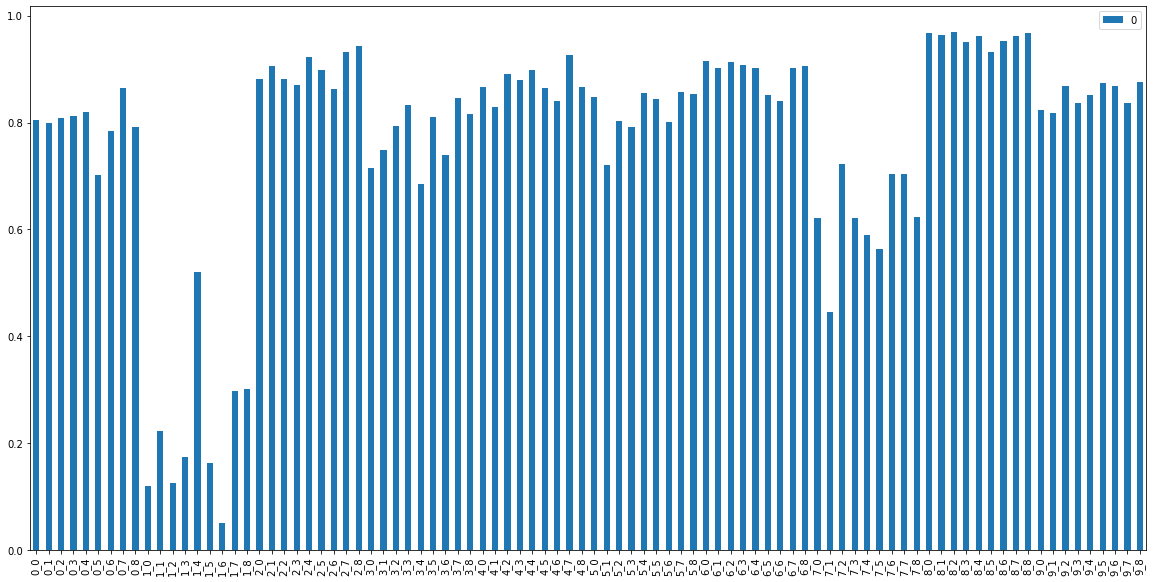

In [56]:
idd=40
devs[idd]
m = devs[idd].get_senders_perc_normal()
pd.DataFrame.from_dict(m, orient='index').plot.bar(figsize=(20,10))

In [57]:
out = ""
filegraph = dataset_name + '.ncol'
for m in devs:
    devs_federated = m.get_devs_federated(0.06)
    for i in devs_federated:
        if i != m:
            out = out + str(m)+'\t'+str(i)+"\n"
        elif len(devs_federated)==1:
            # come si mettono in ncol i vertici isolati? inconcludente, mettiano autoring per ora va bene
            out = out + str(m)+'\t'+str(i)+"\n"

with open(filegraph, 'w') as f:
    f.write(out)

4696

In [58]:
from igraph import *
toy_g = read(filegraph, format = "ncol", directed = True)
summary(toy_g, verbosity = 1, max_rows = 25, edge_list_format = "edgelist")
#assert toy_g.vcount() == 90

# come si mettono in ncol i vertici isolati? inconcludente
#toy_g.add_vertices(["80_10", "80_11"])
#write(toy_g, "./zfacebook.ncol", format = "ncol")

print(toy_g.vcount())

IGRAPH DN-- 90 587 -- 
+ attr: name (v)
+ edges (vertex names):
         edge  
[0]    0_0->0_1
[1]    0_0->0_2
[2]    0_0->0_3
[3]    0_0->0_4
[4]    0_0->0_5
[5]    0_0->0_6
[6]    0_0->0_8
[7]    0_1->0_0
[8]    0_1->0_3
[9]    0_1->0_4
[10]   0_1->0_5
[11]   0_1->0_6
[12]   0_1->0_8
[13]   0_2->0_0
[14]   0_2->0_3
[15]   0_2->0_4
[16]   0_2->0_5
[17]   0_2->0_6
[18]   0_2->0_7
[19]   0_2->0_8
[20]   0_3->0_0
[21]   0_3->0_1
[22]   0_3->0_2
[23]   0_3->0_4
[24]   0_3->0_5
90


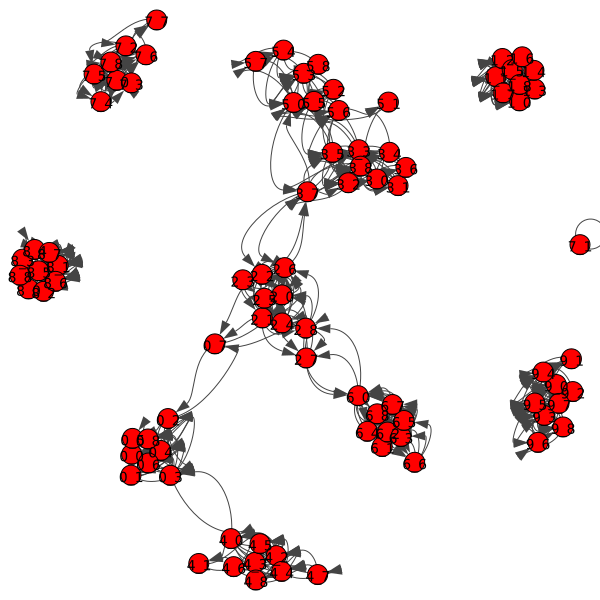

In [59]:
# Compute the layout, using one of the possible methods (Fructherman-Reingold)
toy_g.vs["label"] = toy_g.vs["name"]
layout = toy_g.layout_fruchterman_reingold()

# Plot the graph
plot(toy_g, layout = layout)

9

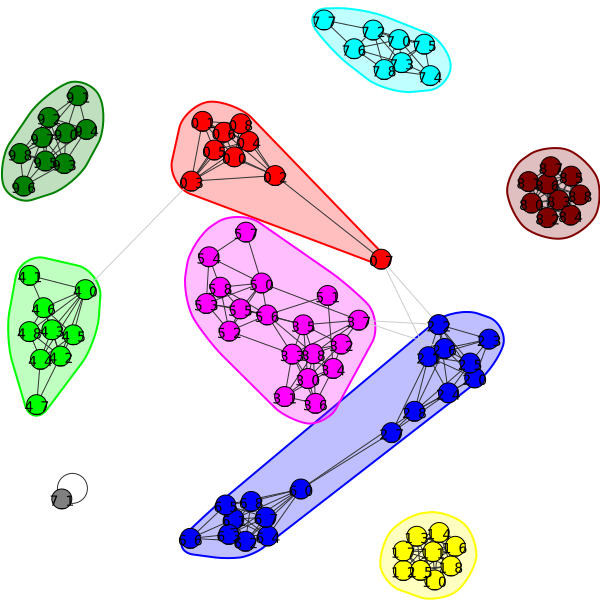

array([28, 29, 30, 94, 95])

Clustering with 90 elements and 9 clusters
0_0, 0_1, 0_2, 0_3, 0_4, 0_5, 0_6, 0_8, 0_7
4_0, 4_1, 4_2, 4_3, 4_4, 4_5, 4_6, 4_8, 4_7
2_1, 2_2, 2_0, 2_3, 2_4, 2_5, 2_6, 2_8, 2_7, 6_0, 6_1, 6_2, 6_3, 6_4, 6_5, 6_7, 6_8, 6_6
1_0, 1_1, 1_2, 1_3, 1_4, 1_5, 1_6, 1_7, 1_8
3_7, 3_0, 3_1, 3_2, 3_3, 3_4, 3_5, 3_6, 3_8, 5_2, 5_6, 5_1, 5_5, 5_0, 5_3, 5_4, 5_7, 5_8
7_0, 7_2, 7_3, 7_4, 7_5, 7_6, 7_8, 7_7
7_1
8_0, 8_1, 8_2, 8_3, 8_4, 8_5, 8_6, 8_7, 8_8
9_0, 9_1, 9_2, 9_3, 9_4, 9_5, 9_7, 9_8, 9_6


In [60]:
toy_g_u = toy_g.as_undirected(combine_edges = "sum")
idx = np.argwhere(np.array(toy_g_u.degree())>0).flatten()
sub_g1 = toy_g_u.induced_subgraph(idx)

# Fastgreedy algorithm
vd = sub_g1.community_fastgreedy()



# The number of detected communities
vd.optimal_count

# convert to a cluster object to plot it nicely
vd_clust = vd.as_clustering()
plot(vd_clust, layout=sub_g1.layout_fruchterman_reingold(), mark_groups = True)

# identify the indices of edges that cut across different communities
cros = np.array(vd_clust.crossing())
np.argwhere(cros == True).flatten()
summary(vd_clust, verbosity = 1)
#summary(vd, verbosity = 1)

In [61]:
vd_clust.summary(verbosity=1)
with open('zz.txt', 'w') as f:
    f.write(vd_clust.summary(verbosity=1))

'Clustering with 90 elements and 9 clusters\n0_0, 0_1, 0_2, 0_3, 0_4, 0_5, 0_6, 0_8, 0_7\n4_0, 4_1, 4_2, 4_3, 4_4, 4_5, 4_6, 4_8, 4_7\n2_1, 2_2, 2_0, 2_3, 2_4, 2_5, 2_6, 2_8, 2_7, 6_0, 6_1, 6_2, 6_3, 6_4, 6_5, 6_7, 6_8, 6_6\n1_0, 1_1, 1_2, 1_3, 1_4, 1_5, 1_6, 1_7, 1_8\n3_7, 3_0, 3_1, 3_2, 3_3, 3_4, 3_5, 3_6, 3_8, 5_2, 5_6, 5_1, 5_5, 5_0, 5_3, 5_4, 5_7, 5_8\n7_0, 7_2, 7_3, 7_4, 7_5, 7_6, 7_8, 7_7\n7_1\n8_0, 8_1, 8_2, 8_3, 8_4, 8_5, 8_6, 8_7, 8_8\n9_0, 9_1, 9_2, 9_3, 9_4, 9_5, 9_7, 9_8, 9_6'

483

In [39]:
with open('zz.txt') as file:
    lines = file.readlines()[1:]
    lines = [line.strip().split(',') for line in lines]

In [40]:
lines

[['0_0',
  ' 0_1',
  ' 0_2',
  ' 0_3',
  ' 0_4',
  ' 0_5',
  ' 0_6',
  ' 0_7',
  ' 0_8',
  ' 3_0',
  ' 3_2',
  ' 3_3',
  ' 3_4',
  ' 3_5',
  ' 3_6',
  ' 3_7',
  ' 3_8',
  ' 4_4',
  ' 4_6',
  ' 2_0',
  ' 2_3',
  ' 2_4',
  ' 2_5',
  ' 2_6',
  ' 6_8',
  ' 2_2',
  ' 4_5',
  ' 4_7',
  ' 2_8',
  ' 2_1',
  ' 3_1',
  ' 4_0',
  ' 4_1',
  ' 4_2',
  ' 4_3',
  ' 4_8'],
 ['2_7', ' 6_1', ' 6_2', ' 6_4', ' 6_6', ' 6_3', ' 6_5', ' 6_7'],
 ['6_0',
  ' 8_2',
  ' 8_3',
  ' 8_6',
  ' 8_1',
  ' 8_0',
  ' 8_4',
  ' 8_5',
  ' 8_7',
  ' 8_8'],
 ['1_0', ' 1_1', ' 1_2', ' 1_3', ' 1_5', ' 1_6', ' 1_7', ' 1_8', ' 1_4'],
 ['5_0', ' 5_1', ' 5_2', ' 5_4', ' 5_5', ' 5_7', ' 5_3', ' 5_6', ' 5_8'],
 ['7_0', ' 7_3', ' 7_5', ' 7_6', ' 7_7', ' 7_1', ' 7_2', ' 7_4', ' 7_8'],
 ['9_8', ' 9_0', ' 9_1', ' 9_2', ' 9_3', ' 9_4', ' 9_5', ' 9_6', ' 9_7']]

In [41]:
filename = 'clust_'+dataset_name+str(num_nodes_per_class)+'.txt'
#vd_clust.summary(verbosity=1)
#with open(filename, 'w') as f:
    #f.write(vd_clust.summary(verbosity=1))

lll = [sorted(i.strip().replace(' ', '').split(',')) for i in vd_clust.summary(verbosity=1).split("\n")]
with open(filename, 'w') as f:
    for line in lll:
        f.write(', '.join(line)+'\n')

37

179

39

49

44

44

44

44

: 